## Image Segmentation with U-Net
In this lab you will learn how to train an image segmentation model at scale with Vertex AI.

Learning Objectives:
* Learn how to preprocess and augment data for image segmentation
* Learn how to build a U-net architecture with `tf.keras`
* Learn how to train this model with Vertex AI
* Learn how to serve and parse predictions 

#### Setup

In [1]:
import time
from datetime import datetime

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

PROJECT = !(gcloud config get-value project)
PROJECT = PROJECT[0]
REGION = "us-central1"
BUCKET = PROJECT
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
OUTPUT_DIR = f"gs://{BUCKET}/pets/models/{TIMESTAMP}"

#### Visualize the data
The dataset used in this lab in the [Oxford Pet Dataset](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet). It contains images of animals with segmentation masks. The goal of an image segmentation model is to take in as input an image and predict the segmentation mask. Think multi-classification problem, where each pixel is labelled as background, interior, or outline. 

In [2]:
def read_and_preprocess(data):
    input_image = tf.image.resize(data["image"], (128, 128))
    input_mask = tf.image.resize(data["segmentation_mask"], (128, 128))

    input_image = tf.image.convert_image_dtype(input_image, tf.float32)  # [0,1]
    input_mask -= 1  # {1,2,3} to {0,1,2}
    return input_image, input_mask

2022-06-16 15:13:15.610872: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-16 15:13:15.610942: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tensorflow-2-6-20220614-124846): /proc/driver/nvidia/version does not exist
2022-06-16 15:13:15.611817: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


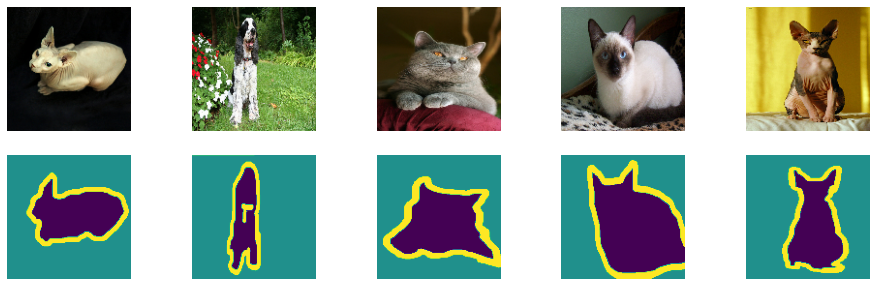

In [3]:
# Load in the dataset with tfds
dataset, info = tfds.load(
    "oxford_iiit_pet",
    data_dir="gs://asl-public/data/tensorflow_datasets",
    with_info=True,
)

train = dataset["train"].map(
    read_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
test = dataset["test"].map(read_and_preprocess)

f, ax = plt.subplots(2, 5, figsize=(16, 5))
for idx, (img, mask) in enumerate(train.take(5)):
    ax[0, idx].imshow(tf.keras.preprocessing.image.array_to_img(img))
    ax[0, idx].axis("off")
    mask = tf.reshape(mask, [128, 128])
    ax[1, idx].imshow(mask.numpy())
    ax[1, idx].axis("off")

### Modified U-Net

The model being used here is a modified U-Net. A U-Net typically consists of an encoder which downsamples an image to an encoding, and a mirrored decoder which upsamples the encoding back to the desired mask. The decoder blocks have a number of skip connections that directly connect the encoder blocks to the decoder.

Doing this from scratch requires a lot of trainable parameters and is better done using Generative Adversarial Networks (GANs).

In this notebook, we will use a pretrained MobileNetV2 to create the encoding and a set of upsampling layers to get back to the desired mask. When doing so, however, we will pull out layers with the desired sizes so that the upsampling skip layers use corresponding weights from the pretrained models.

To make the dataset go a little bit farther, we also augment the training dataset to flip the images.

Note that the output consists of 3 channels. This is because we have 3 possible labels for each pixel (background, outline, interior). Think of this as multi-classification problem with three possible classes.

In [4]:
!mkdir ./pets_trainer

mkdir: cannot create directory ‘./pets_trainer’: File exists


In [5]:
%%writefile ./pets_trainer/train.py

import tensorflow as tf
import tensorflow_datasets as tfds
import fire

def read_and_preprocess(data):
    input_image = tf.image.resize(data['image'], (128,128))
    input_mask = tf.image.resize(data['segmentation_mask'], (128,128))
    
    input_image = tf.image.convert_image_dtype(input_image, tf.float32) # [0,1]
    input_mask -= 1 # {1,2,3} to {0,1,2}
    return input_image, input_mask
    
def augment(img, mask):
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    return img, mask
    
def create_train_test_datasets(dataset, batch_size):
    train_ds = dataset['train'].map(read_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = dataset['test'].map(read_and_preprocess)
    train_ds = train_ds.cache().map(augment).shuffle(10 * batch_size).batch(batch_size).repeat()
    train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    test_ds = test_ds.batch(batch_size)
    return train_ds, test_ds
    
def upsample(filters, size, name):
    return tf.keras.Sequential([
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU()], name=name)

def build_unet(input_shape, output_channels):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False)
    
    # Use the activations of these layers to form skip connections
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]
    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
    
    # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs,
                                name='pretrained_mobilenet')

    down_stack.trainable = False
    
    up_stack = [
        upsample(512, 3, 'upsample_4x4_to_8x8'),
        upsample(256, 3, 'upsample_8x8_to_16x16'),
        upsample(128, 3, 'upsample_16x16_to_32x32'),
        upsample(64, 3,  'upsample_32x32_to_64x64')
    ]
    
    inputs = tf.keras.layers.Input(shape=input_shape, name='input_image')
    
    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])
    
    # Upsampling and establishing the skip connections
    for idx, (up, skip) in enumerate(zip(up_stack, skips)):
        x = up(x)
        concat = tf.keras.layers.Concatenate(name='expand_{}'.format(idx))
        x = concat([x, skip])
        
    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  #64x64 -> 128x128
    
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)
    
    
def train_evaluate(
    batch_size=64,
    tf_dataset='oxford_iiit_pet',
    data_dir='gs://asl-public/data/tensorflow_datasets',
    input_shape=[128,128,3],
    output_channels=3,
    epochs=10,
    output_dir=None
):
    
    # Download dataset from tfds
    dataset, info = tfds.load(tf_dataset, data_dir=data_dir, with_info=True)
    
    # Create train and test datasets
    train_ds, test_ds = create_train_test_datasets(dataset, batch_size)
    
    steps_per_epoch = info.splits['train'].num_examples // batch_size
    validation_steps = info.splits['test'].num_examples // batch_size
    
    model = build_unet(input_shape, output_channels)
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])
    
    history = model.fit(
        train_ds, 
        validation_data=test_ds,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps)
    
    if output_dir:
        model.save(output_dir)
        
if __name__ == '__main__':
    fire.Fire(train_evaluate)

Overwriting ./pets_trainer/train.py


#### Write Dockerfile

In [6]:
%%writefile ./pets_trainer/Dockerfile
FROM gcr.io/deeplearning-platform-release/tf2-gpu.2-8

# Installs fire
RUN pip install -U fire

# Copies the trainer code to the docker image.
WORKDIR /app
COPY train.py .

# Sets up the entry point to invoke the trainer.
ENTRYPOINT ["python", "train.py"]

Overwriting ./pets_trainer/Dockerfile


#### Build and push containerized training application

In [7]:
IMAGE_NAME = "pets_trainer_tf"
TAG = "latest"
TRAINING_CONTAINER_IMAGE_URI = f"gcr.io/{PROJECT}/{IMAGE_NAME}:{TAG}"
TRAINING_CONTAINER_IMAGE_URI

'gcr.io/kylesteckler-demo/pets_trainer_tf:latest'

In [8]:
!gcloud builds submit --machine-type=e2-highcpu-32 --timeout=15m --tag $TRAINING_CONTAINER_IMAGE_URI pets_trainer

Creating temporary tarball archive of 2 file(s) totalling 4.2 KiB before compression.
Uploading tarball of [pets_trainer] to [gs://kylesteckler-demo_cloudbuild/source/1655392416.726216-214cc69c914242baaf4b18803d7a2ef1.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/kylesteckler-demo/locations/global/builds/2e236c20-4ecd-4621-a7e7-e3d40e4e8fac].
Logs are available at [https://console.cloud.google.com/cloud-build/builds/2e236c20-4ecd-4621-a7e7-e3d40e4e8fac?project=693210680039].
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "2e236c20-4ecd-4621-a7e7-e3d40e4e8fac"

FETCHSOURCE
Fetching storage object: gs://kylesteckler-demo_cloudbuild/source/1655392416.726216-214cc69c914242baaf4b18803d7a2ef1.tgz#1655392416924088
Copying gs://kylesteckler-demo_cloudbuild/source/1655392416.726216-214cc69c914242baaf4b18803d7a2ef1.tgz#1655392416924088...
/ [1 files][  1.9 KiB/  1.9 KiB]                                                
Operation compl

#### Run Custom Training Job on Vertex AI 

In [9]:
# Specify variables used to configure hyperparameter tuning job
DISPLAY_NAME = "pets-segmentation"
JOB_NAME = f"unet-custom-training-{TIMESTAMP}"
STAGING_BUCKET = f"gs://{BUCKET}"
EPOCHS = 50

In [10]:
from google.cloud import aiplatform

# Define required specifications
worker_pool_specs = [
    {
        "machine_spec": {
            "machine_type": "n1-standard-8",
            "accelerator_type": "NVIDIA_TESLA_T4",
            "accelerator_count": 1,
        },
        "replica_count": 1,
        "container_spec": {
            "image_uri": TRAINING_CONTAINER_IMAGE_URI,
            "args": [f"--output_dir={OUTPUT_DIR}", f"--epochs={EPOCHS}"],
        },
    }
]

custom_job = aiplatform.CustomJob(
    display_name=JOB_NAME,
    project=PROJECT,
    worker_pool_specs=worker_pool_specs,
    staging_bucket=STAGING_BUCKET,
)

In [11]:
custom_job.run()

Creating CustomJob


INFO:google.cloud.aiplatform.jobs:Creating CustomJob


CustomJob created. Resource name: projects/693210680039/locations/us-central1/customJobs/8445595378429984768


INFO:google.cloud.aiplatform.jobs:CustomJob created. Resource name: projects/693210680039/locations/us-central1/customJobs/8445595378429984768


To use this CustomJob in another session:


INFO:google.cloud.aiplatform.jobs:To use this CustomJob in another session:


custom_job = aiplatform.CustomJob.get('projects/693210680039/locations/us-central1/customJobs/8445595378429984768')


INFO:google.cloud.aiplatform.jobs:custom_job = aiplatform.CustomJob.get('projects/693210680039/locations/us-central1/customJobs/8445595378429984768')


View Custom Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/8445595378429984768?project=693210680039


INFO:google.cloud.aiplatform.jobs:View Custom Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/8445595378429984768?project=693210680039


CustomJob projects/693210680039/locations/us-central1/customJobs/8445595378429984768 current state:
JobState.JOB_STATE_PENDING


INFO:google.cloud.aiplatform.jobs:CustomJob projects/693210680039/locations/us-central1/customJobs/8445595378429984768 current state:
JobState.JOB_STATE_PENDING


CustomJob projects/693210680039/locations/us-central1/customJobs/8445595378429984768 current state:
JobState.JOB_STATE_PENDING


INFO:google.cloud.aiplatform.jobs:CustomJob projects/693210680039/locations/us-central1/customJobs/8445595378429984768 current state:
JobState.JOB_STATE_PENDING


CustomJob projects/693210680039/locations/us-central1/customJobs/8445595378429984768 current state:
JobState.JOB_STATE_PENDING


INFO:google.cloud.aiplatform.jobs:CustomJob projects/693210680039/locations/us-central1/customJobs/8445595378429984768 current state:
JobState.JOB_STATE_PENDING


CustomJob projects/693210680039/locations/us-central1/customJobs/8445595378429984768 current state:
JobState.JOB_STATE_PENDING


INFO:google.cloud.aiplatform.jobs:CustomJob projects/693210680039/locations/us-central1/customJobs/8445595378429984768 current state:
JobState.JOB_STATE_PENDING


CustomJob projects/693210680039/locations/us-central1/customJobs/8445595378429984768 current state:
JobState.JOB_STATE_PENDING


INFO:google.cloud.aiplatform.jobs:CustomJob projects/693210680039/locations/us-central1/customJobs/8445595378429984768 current state:
JobState.JOB_STATE_PENDING


CustomJob projects/693210680039/locations/us-central1/customJobs/8445595378429984768 current state:
JobState.JOB_STATE_RUNNING


INFO:google.cloud.aiplatform.jobs:CustomJob projects/693210680039/locations/us-central1/customJobs/8445595378429984768 current state:
JobState.JOB_STATE_RUNNING


CustomJob projects/693210680039/locations/us-central1/customJobs/8445595378429984768 current state:
JobState.JOB_STATE_RUNNING


INFO:google.cloud.aiplatform.jobs:CustomJob projects/693210680039/locations/us-central1/customJobs/8445595378429984768 current state:
JobState.JOB_STATE_RUNNING


CustomJob projects/693210680039/locations/us-central1/customJobs/8445595378429984768 current state:
JobState.JOB_STATE_SUCCEEDED


INFO:google.cloud.aiplatform.jobs:CustomJob projects/693210680039/locations/us-central1/customJobs/8445595378429984768 current state:
JobState.JOB_STATE_SUCCEEDED


CustomJob run completed. Resource name: projects/693210680039/locations/us-central1/customJobs/8445595378429984768


INFO:google.cloud.aiplatform.jobs:CustomJob run completed. Resource name: projects/693210680039/locations/us-central1/customJobs/8445595378429984768


#### Load the trained model and serve predictions

In [13]:
model = tf.keras.models.load_model(OUTPUT_DIR)

In [14]:
# Assign to the pixel the label with the highest probability
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


# display helper functions
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()


def show_predictions(dataset, num):
    for image, mask in dataset.take(num):
        pred_mask = model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])

1/1 [==============================] - 0s 90ms/step


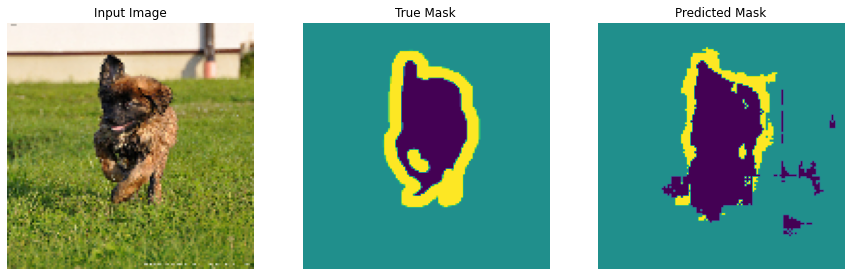

1/1 [==============================] - 0s 88ms/step


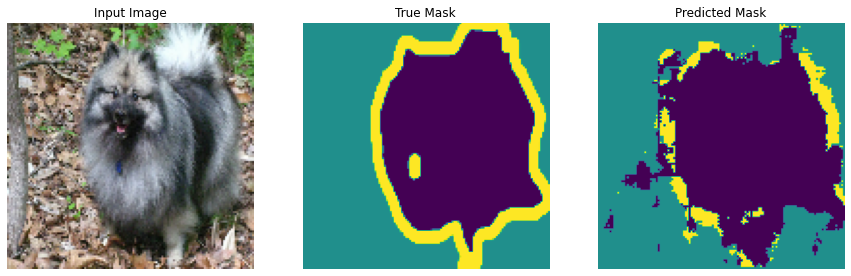

1/1 [==============================] - 0s 78ms/step


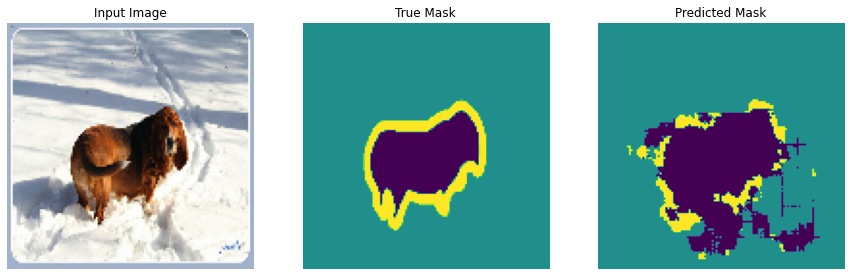

1/1 [==============================] - 0s 76ms/step


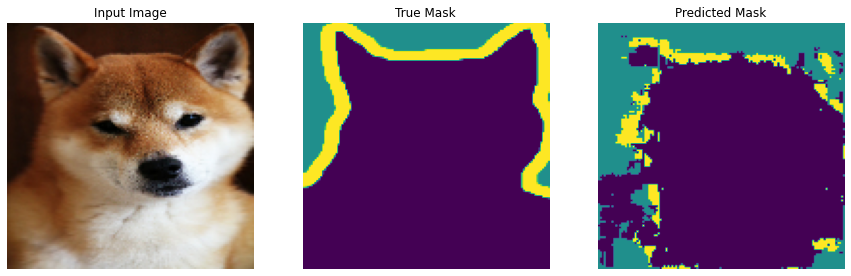

1/1 [==============================] - 0s 90ms/step


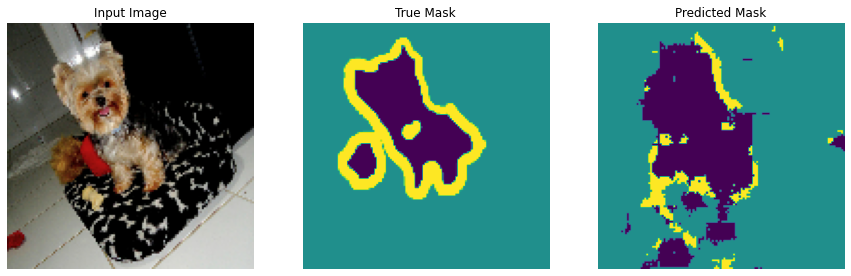

In [16]:
show_predictions(test.batch(5), 5)

Congrats! You've succesfully trained a custom U-net model for image segmentation using Vertex AI. To improve performance further:
* Train for longer
* Try a different model architecture (like Mask-R CNN)